Accuracy of Happy: 85.10% (1553/1825)
Accuracy of Neutral: 62.75% (763/1216)
Accuracy of Sad: 77.14% (1664/2157)

Overall Accuracy: 76.57% (3980/5198)
F1 Score of Happy: 0.8676
F1 Score of Neutral: 0.6183
F1 Score of Sad: 0.7654


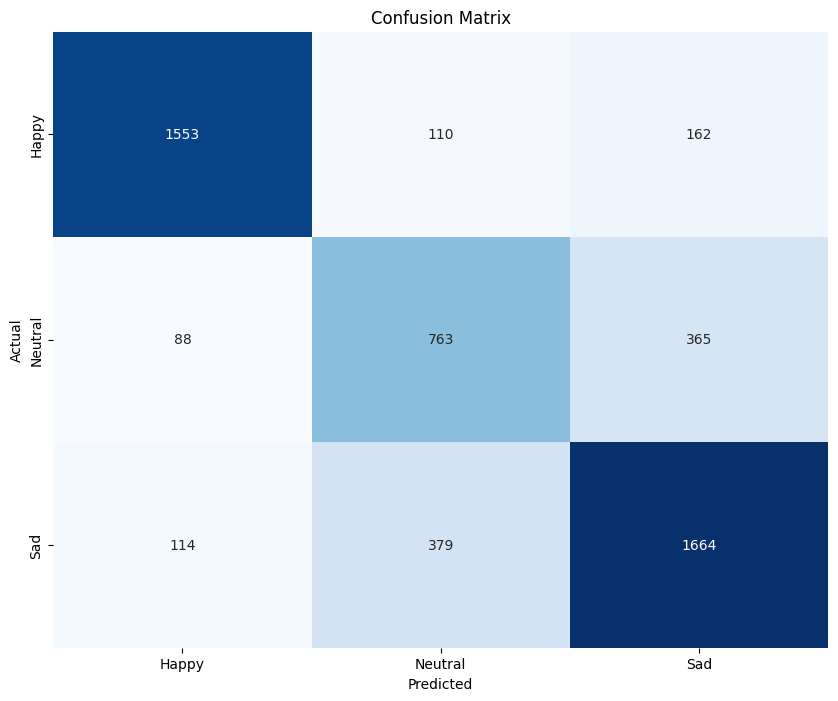

In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets import ImageFolder


# Assuming you have a model class defined
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(
            4608, 512
        )  # Adjusted the input size based on the flattened tensor size
        self.batchnorm5 = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(512, 128)
        self.batchnorm6 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.batchnorm1(self.conv1(x))))
        x = self.pool(F.relu(self.batchnorm2(self.conv2(x))))

        x = self.pool(F.relu(self.batchnorm3(self.conv3(x))))

        x = self.flatten(x)

        x = F.relu(self.batchnorm5(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.batchnorm6(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)

        return x


testTransfrom = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

# Create an instance of your model
model = Net()

# Load the trained weights from the model file
model.load_state_dict(torch.load("model.pt"))
model.eval()

validationPath = "images/validation/"
testDataSet = ImageFolder(root=validationPath, transform=testTransfrom)
testDataLoader = DataLoader(testDataSet, batch_size=64, shuffle=True)

# Track predictions and true labels
all_predictions = []
all_labels = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Iterate over the test data
with torch.no_grad():
    for data, target in testDataLoader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()

        # Forward pass
        output = model(data)

        # Convert output probabilities to predicted class
        _, pred = torch.max(output, 1)

        # Accumulate predictions and true labels
        all_predictions.extend(pred.cpu().numpy())
        all_labels.extend(target.cpu().numpy())
classes = ["Happy", "Neutral", "Sad"]
class_correct = [0] * len(classes)
class_total = [0] * len(classes)

for i in range(len(all_labels)):
    label = all_labels[i]
    prediction = all_predictions[i]
    class_correct[label] += int(label == prediction)
    class_total[label] += 1

# Print accuracy for each class
for i, class_name in enumerate(classes):
    accuracy = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
    print(
        f"Accuracy of {class_name}: {accuracy:.2f}% ({class_correct[i]}/{class_total[i]})"
    )

# Print overall accuracy
overall_accuracy = (
    100 * np.sum(class_correct) / np.sum(class_total) if np.sum(class_total) > 0 else 0
)
print(
    f"\nOverall Accuracy: {overall_accuracy:.2f}% ({np.sum(class_correct)}/{np.sum(class_total)})"
)

# Calculate and print F1 score for each class
f1_scores = f1_score(all_labels, all_predictions, average=None)
for i, class_name in enumerate(classes):
    print(f"F1 Score of {class_name}: {f1_scores[i]:.4f}")

# Create a confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Visualize the confusion matrix using seaborn and matplotlib
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=classes,
    yticklabels=classes,
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()